In [1]:
import mne, os, numpy as np, matplotlib.pyplot as plt
import local
from models.preprocessing import utils
from joblib import Parallel,delayed

In [2]:
def get_epochs(f):
    epochs = mne.read_epochs(f)
    montage = mne.channels.read_montage('easycap-M1',ch_names=epochs.ch_names)
    epochs.set_montage(montage)
    return epochs.set_eeg_reference(projection=True)

In [3]:
d = "G:\\Frederik\\data\\reinhartlab\\multimodal\\"
#d = "../../../../../Desktop/Julia/New_Datasets/RawData_new/"
prefix = "betw"
ext_in = "-epo.fif.gz"
box=utils.select_dataset(d,ext_in);box

In [4]:
# Define wavelet frequencies and number of cycles
cwt_freqs = np.arange(7, 30, 2)
cwt_n_cycles = cwt_freqs / 7.

# Run the connectivity analysis using 2 parallel jobs
def run_connectivity_analysis(filename,seed_ch,tmin=0.,tmax=1.,baseline=(-.2,0.),condition=None):
    epochs = get_epochs(filename).apply_baseline(baseline).crop(tmin=tmin,tmax=tmax)
    if condition is not None:
        epochs=epochs[condition]
    picks = mne.pick_types(epochs.info, eeg=True)
    picks_ch_names = [epochs.ch_names[i] for i in picks]
    seed = picks_ch_names.index(seed_ch)
    targets = np.arange(len(picks))
    indices = mne.connectivity.seed_target_indices(seed, targets)
    sfreq = epochs.info['sfreq']  # the sampling frequency
    con, freqs, times, _, _ = mne.connectivity.spectral_connectivity(
        epochs, indices=indices,
        method='plv', mode='cwt_morlet', sfreq=sfreq,
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=4)

    # Mark the seed channel with a value of 1.0, so we can see it in the plot
    con[np.where(indices[1] == seed)] = 1.0
    #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
    eps = epochs.copy().pick_types(eeg=True)
    return mne.time_frequency.AverageTFR(eps.info, con, times, freqs, len(epochs))
    
files = [d+f+ext_in for f in utils.get_selection(box)]
tfrs = Parallel(n_jobs=12)(delayed(run_connectivity_analysis)(f,"Fz",condition="visual") for f in files)

No baseline correction applied


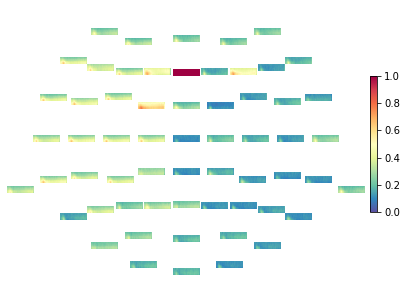

In [22]:
seed_ch='Fz'
tfr = mne.grand_average([t for t in tfrs if len(t.ch_names)==60],False,False)
# Show topography of connectivity from seed
fig=tfr.plot_topo(fig_facecolor='w', font_color='k', border='k',cmap='Spectral_r',vmin=0);
# fig.suptitle('PLV - Visual - Seed %s' % seed_ch);

In [ ]:
tfr.plot(picks=['AFz'],vmin=0,vmax=1,cmap='Spectral_r');